In [11]:
using Random
using Distributions
using LinearAlgebra
include("../../Inversion/Plot.jl")
include("../../Inversion/RWMCMC.jl")
include("../../Inversion/SMC.jl")
include("../../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [12]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

## Rosenbrock banana likelihood function

We will explore the question with the following inverse problem 

$$
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} 
\qquad
\theta_{ref} = 
\begin{bmatrix}
1\\
1
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_{\eta_1}^2 & 0\\
0 & \sigma_{\eta_2}^2
\end{bmatrix} 
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the "uninformative" Gaussian prior $\mathcal{N}(0, 10^2 I)$.
     

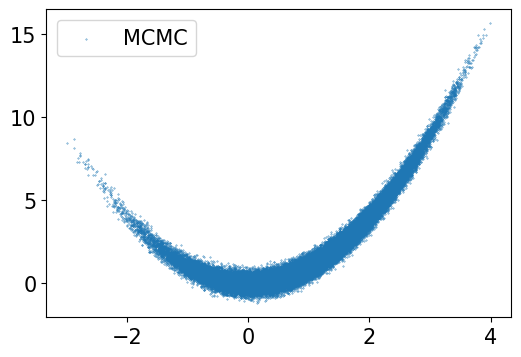

PyObject <matplotlib.legend.Legend object at 0x7ff36209cf50>

In [13]:
function func_G(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [θ₂ - θ₁^2; θ₁]
end

function log_prior(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -((θ₁ - μ0[1])^2 + (θ₂ - μ0[2])^2)/(2σ0^2)
end

function log_Rosenbrock(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    y₁, y₂ = func_G(θ)
    return -(y[1] - y₁)^2/(2ση₁^2) - (y[2] - y₂)^2/(2ση₂^2)  + log_prior(θ)
end

μ0, σ0 = [0.0;0.0], 10.0
Σ0 = [σ0^2 0.0;0.0  σ0^2]


ση₁, ση₂ = sqrt(1/10), sqrt(1)
Σ_η = [ση₁^2  0.0;  0.0  ση₂^2]
y = [0.0; 1.0]


# compute posterior distribution by MCMC

step_length = 0.1
n_ite = 10^7
us = RWMCMC_Run(log_Rosenbrock, μ0, step_length, n_ite);
everymarker = 100
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
n_burn_in, n_end = div(n_ite, 10), n_ite
ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
ax.legend()

## Gaussian Mixture Kalman Inversion

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:81
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


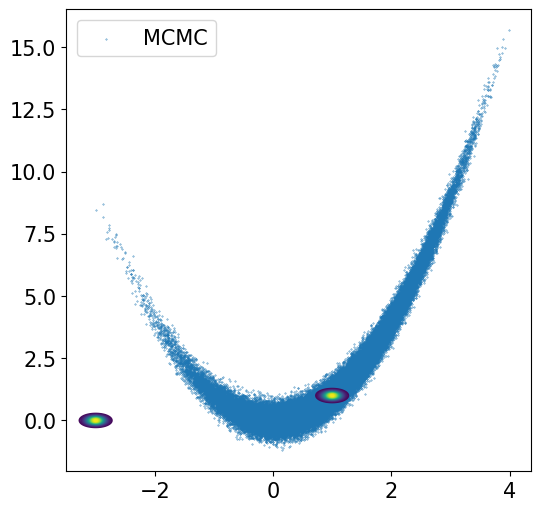

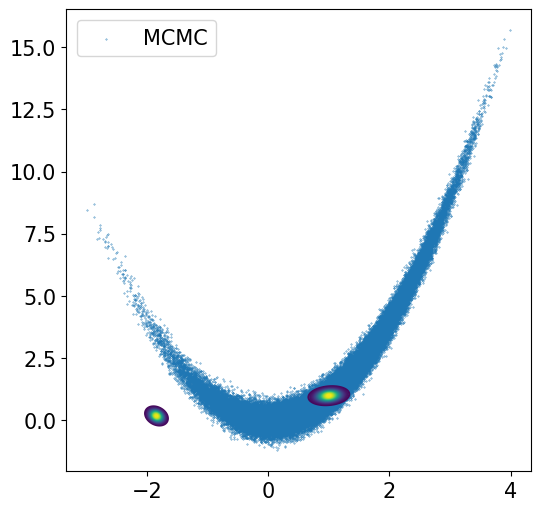

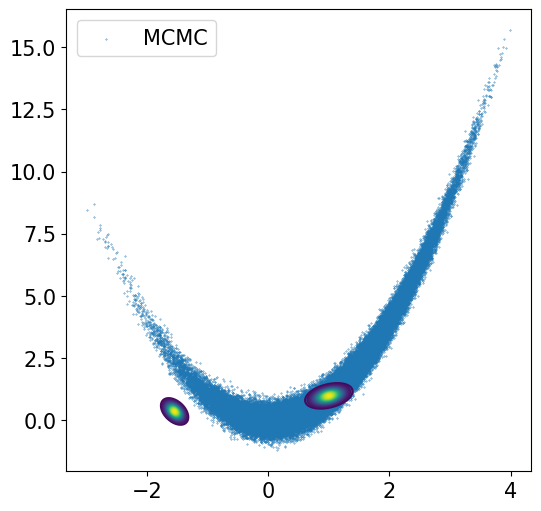

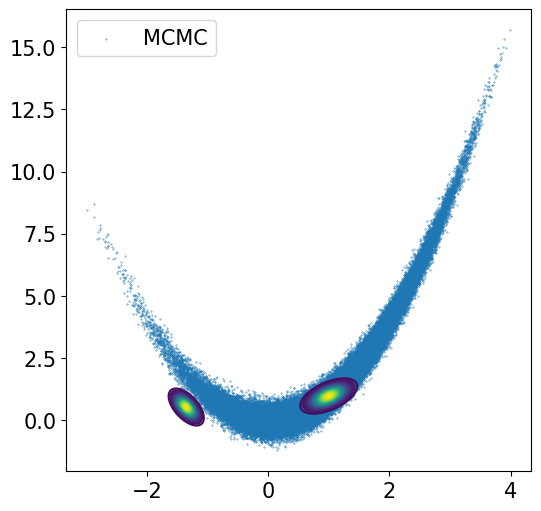

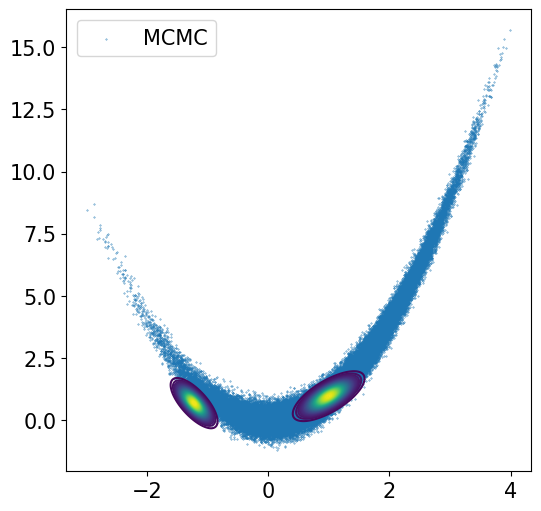

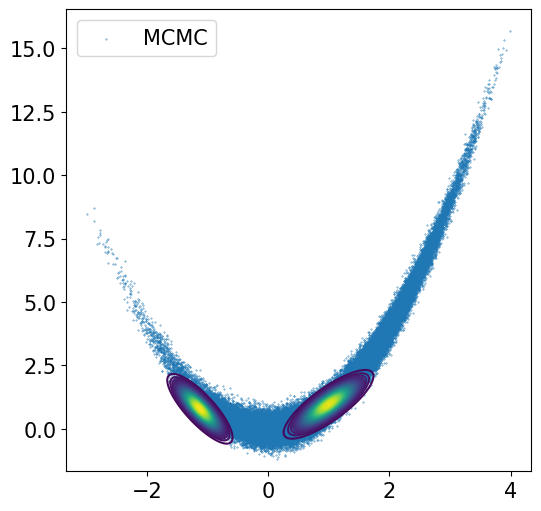

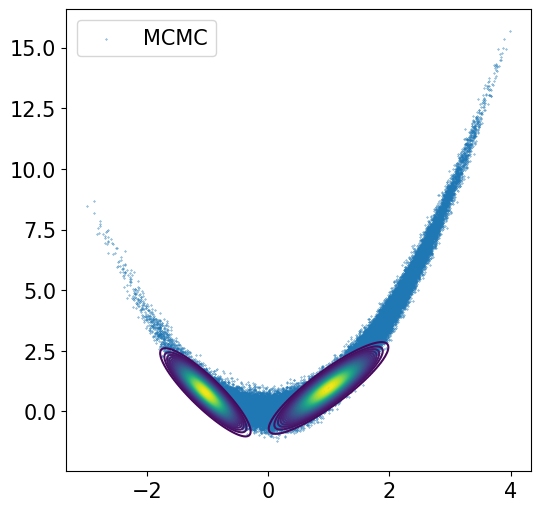

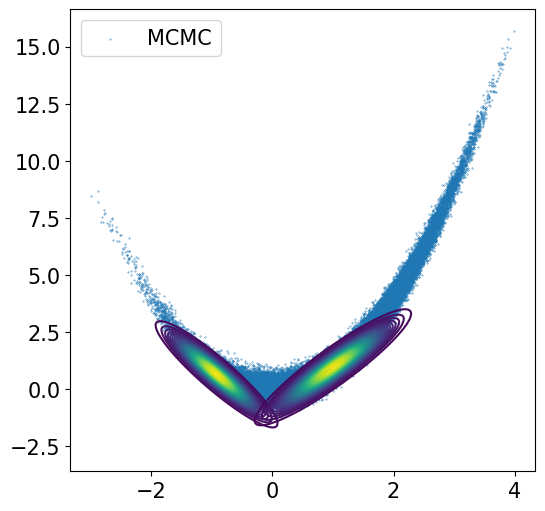

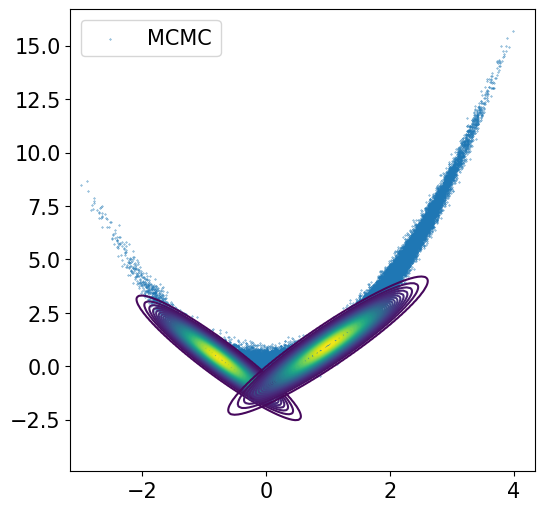

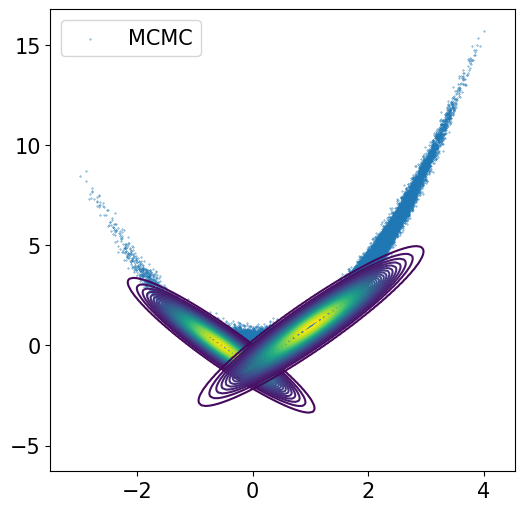

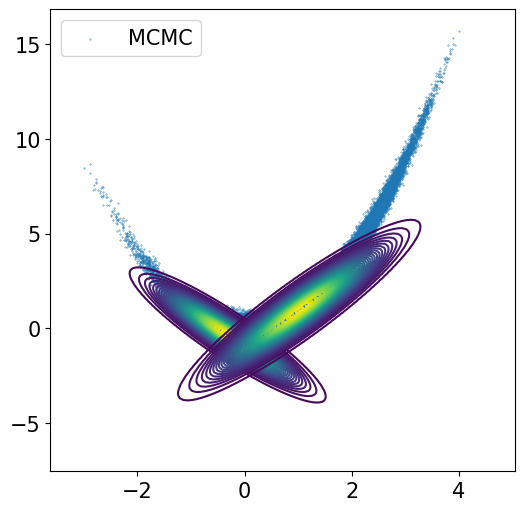

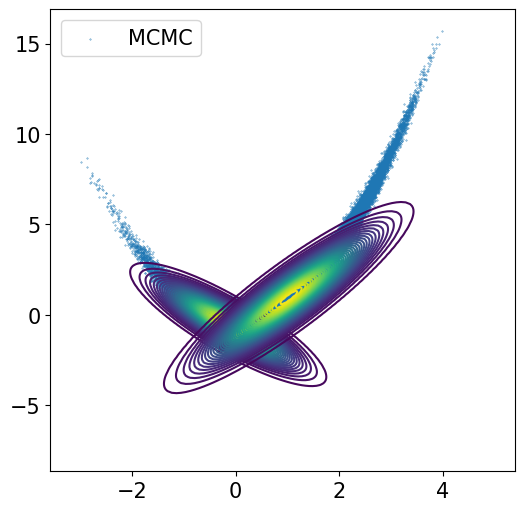

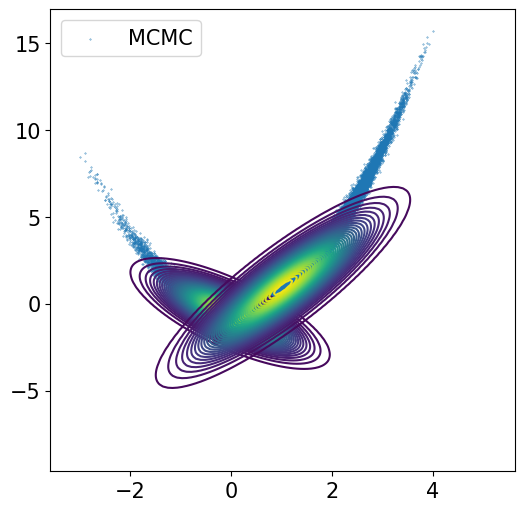

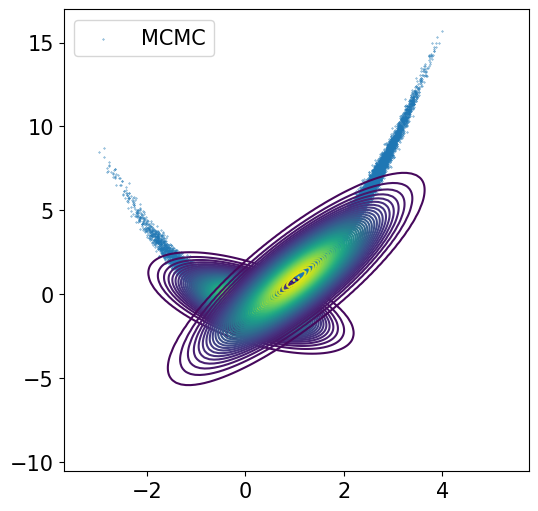

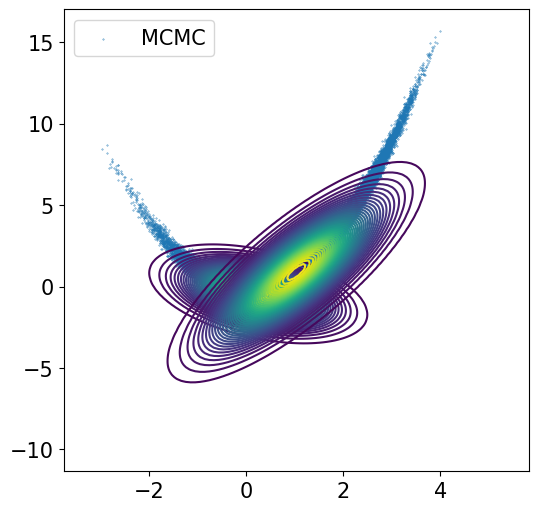

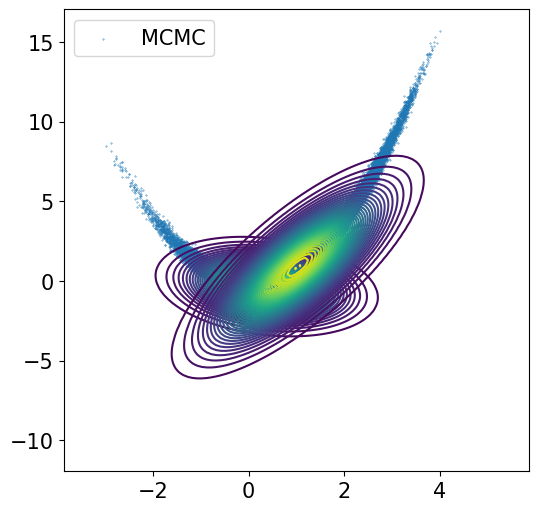

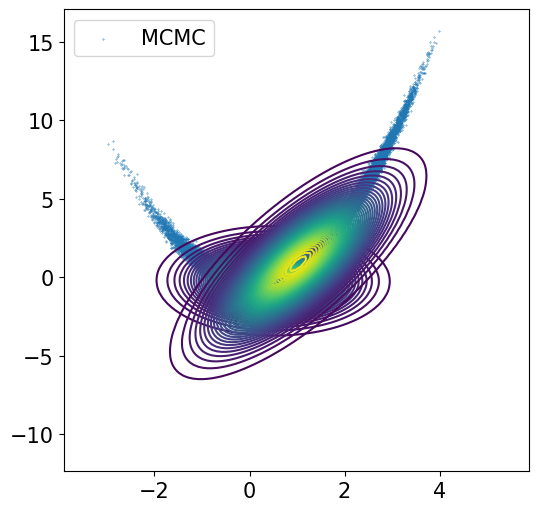

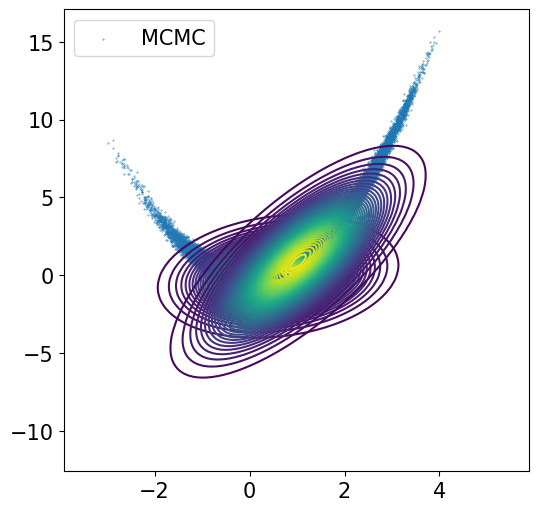

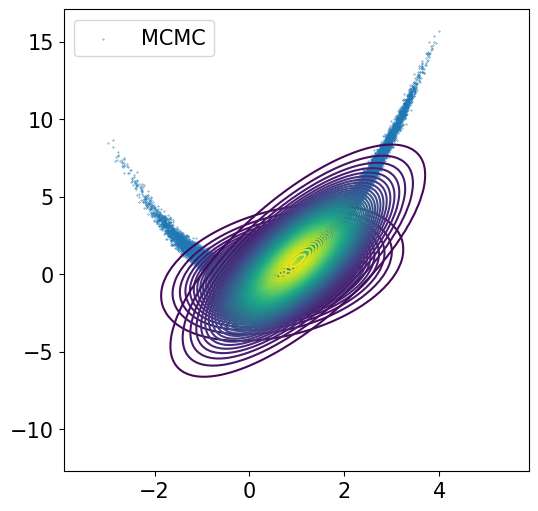

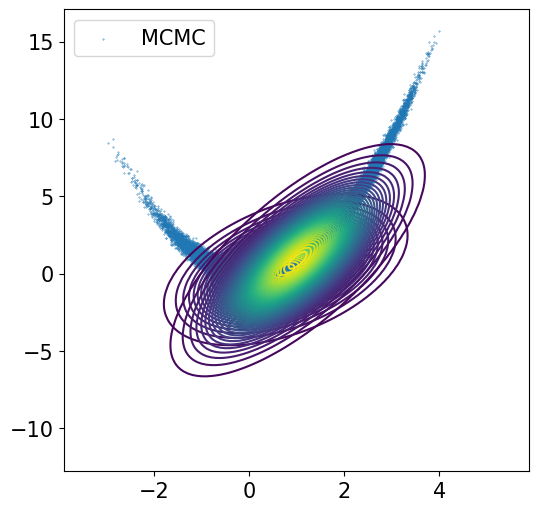

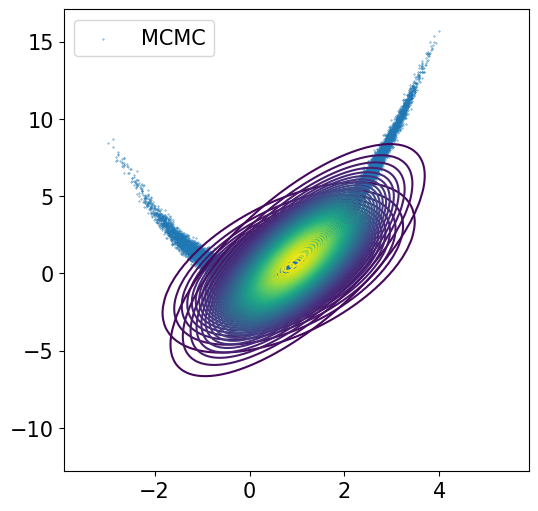

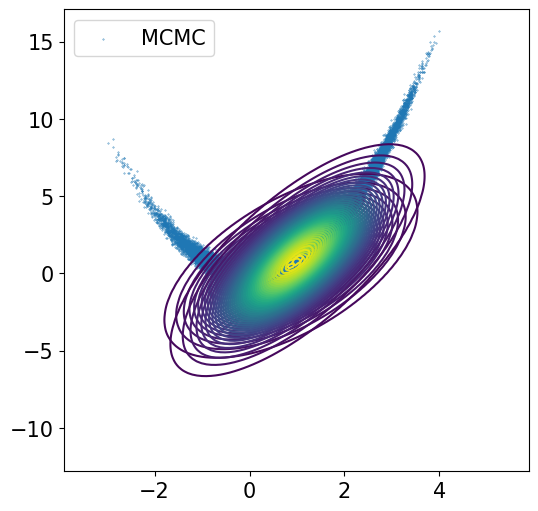

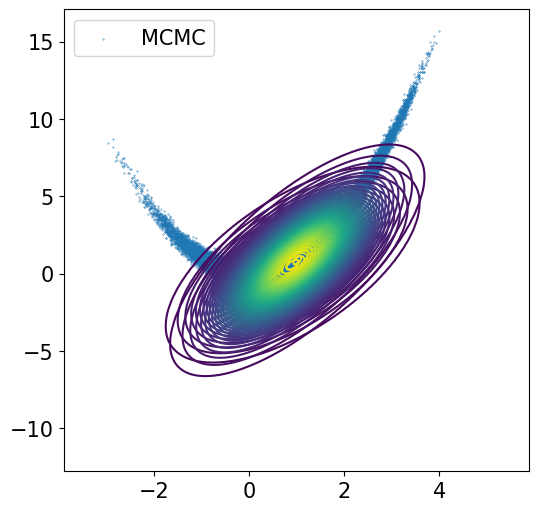

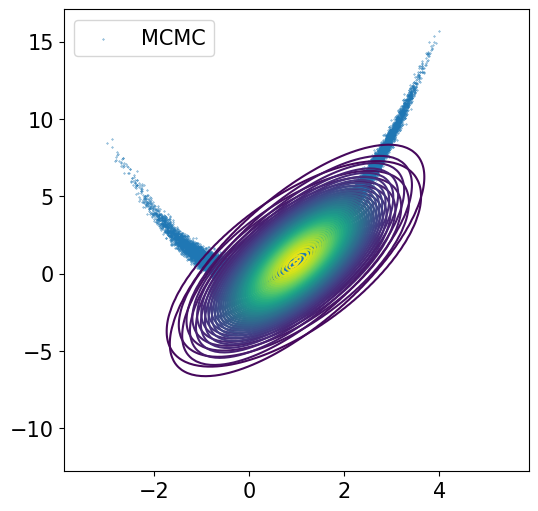

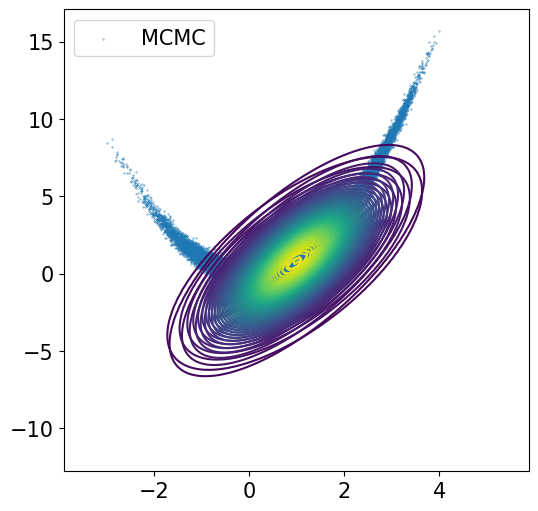

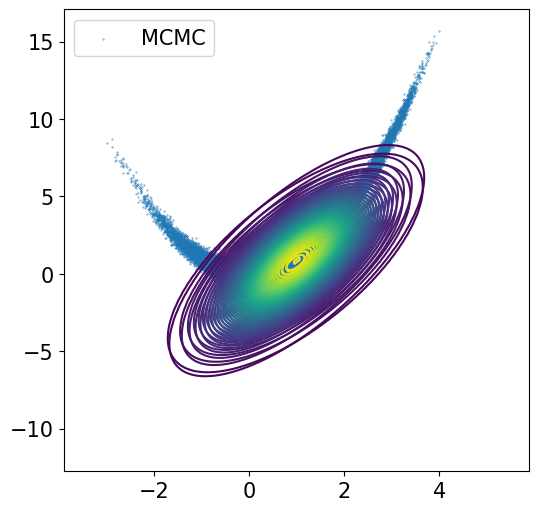

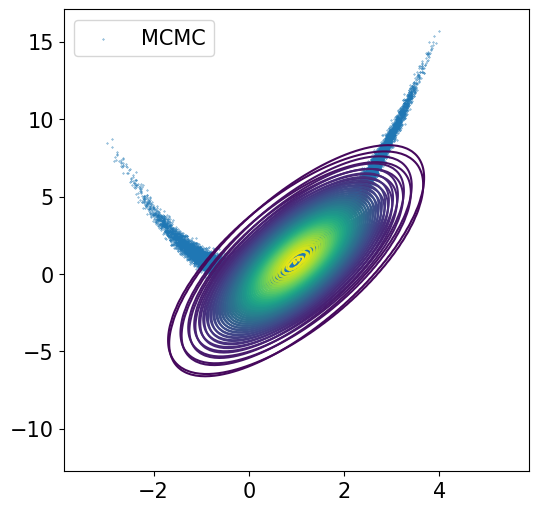

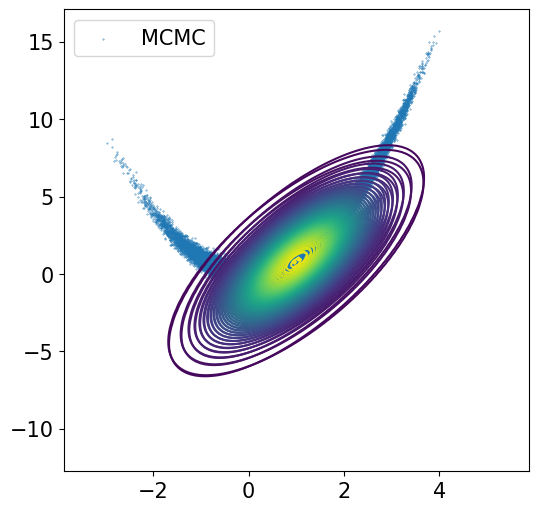

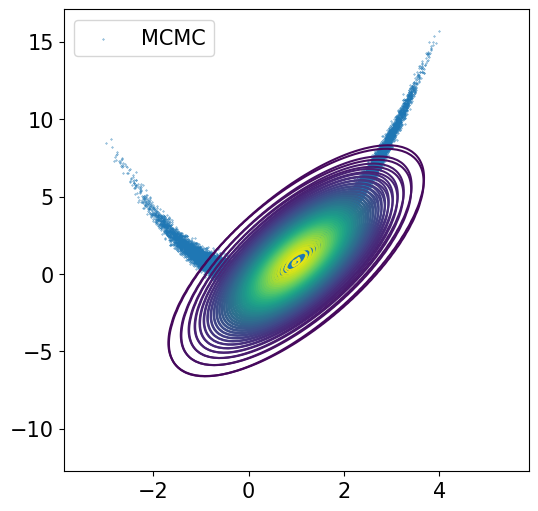

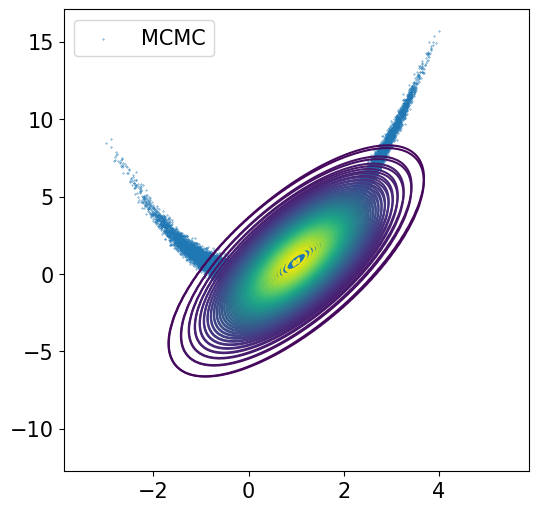

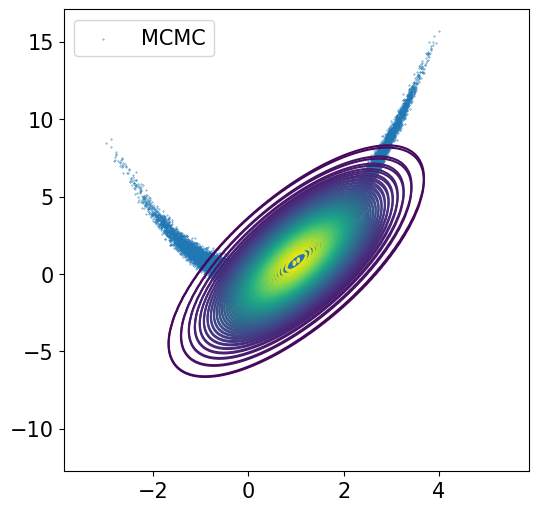

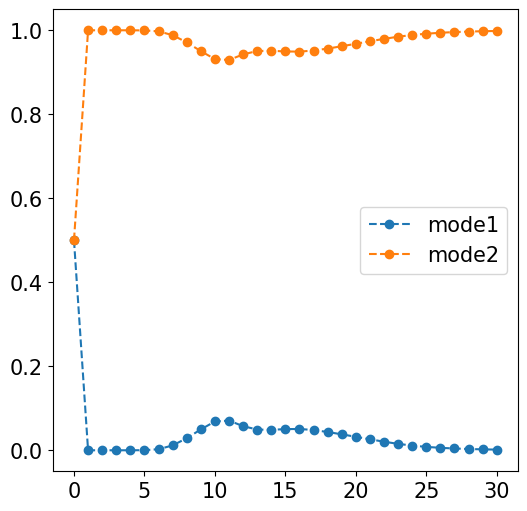

PyObject <matplotlib.legend.Legend object at 0x7ff3860823d0>

In [14]:
include("../../Inversion/KalmanInversion.jl")

function forward(s_param::Setup_Param, θ::Array{Float64,1})
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)

N_y, N_θ = 2, 2
# compute posterior distribution by UKI
update_freq = 1
N_iter = 30
N_modes = 2
θ0_w  = ones(N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

θ0_mean[1, :]    .= [-3.0 ; 0]
θθ0_cov[1, :, :] .= 0.1^2*diagm(ones(N_θ))
θ0_mean[2, :]    .= [1.0 ; 1.0]
θθ0_cov[2, :, :] .= 0.1^2*diagm(ones(N_θ))
# θ0_mean[3, :]    .= [0.0 ; 3.0]
# θθ0_cov[3, :, :] .= 0.1^2*diagm(ones(N_θ))

s_param_aug = Setup_Param(N_θ, N_y+N_θ)
y_aug = [y ; μ0]
Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
γ = 1.0
# Δt = γ/(1+γ)
ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")



# visualization 

# Visualize different iterations
plot_every = 1
Run_MCMC = true
for iter  = 1:plot_every:length(ukiobj.θ_mean)
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 
    
    
    if Run_MCMC
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
    end

    # plot UKI results 
    Nx = 100; Ny = 200
    for i =1:N_modes
        uki_θ_mean = ukiobj.θ_mean[iter][i, :]
        uki_θθ_cov = ukiobj.θθ_cov[iter][i, :, :]
        X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
        ax.contour(X, Y, Z, 50)
    end

    ax.legend()
end


nrows, ncols = 1, 1
fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
θ_w = exp.(hcat(ukiobj.logθ_w...))
for i =1:N_modes
    ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
end
ax.legend()


## Double banana likelihood function

We will explore the question with the following inverse problem 

$$
\begin{align*}
y = 
\log
\Bigl(
(1 - \theta_{(1)})^2 + 100(\theta_{(2)} - \theta_{(1)}^2)^2
\Bigr)
+\eta
\qquad 
\theta_{ref} = 
\begin{bmatrix}
0\\
0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
0.3^2 
\end{bmatrix} 
\end{align*}
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the Gaussian prior $\mathcal{N}(0, 1^2 I)$.
     

In [15]:
function func_G(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [(θ₂ - θ₁)^2;]
end

function log_prior(θ::Array{Float64,1}, μ0, σ0)
    θ₁, θ₂ = θ
    return -((θ₁ - μ0[1])^2 + (θ₂ - μ0[2])^2)/(2σ0^2)
end

function log_double_banana(θ::Array{Float64,1}, μ0, σ0, y, ση)
    θ₁, θ₂ = θ
    return -(y[1] - func_G(θ)[1])^2/ση^2/2 + log_prior(θ, μ0, σ0)
end

function forward(s_param::Setup_Param, θ::Array{Float64,1})
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)



#140 (generic function with 1 method)

In [23]:
using KernelDensity
function double_banana(μ0 = [0.0;0.0]; Run_MCMC = false)

    σ0 = 1.0
    Σ0 = [σ0^2 0.0;0.0  σ0^2]

    ση = 1.0
    Σ_η = [ση^2;;]
    y = [4.2297;]

    @info "y = ", y

    # compute posterior distribution by MCMC
    
    if Run_MCMC
        step_length = 0.1
        n_ite = 10^7
        us = RWMCMC_Run(θ->log_double_banana(θ, μ0, σ0, y, ση), μ0, step_length, n_ite);
        everymarker = 100
        fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
        n_burn_in, n_end = div(n_ite, 10), n_ite
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
        ax.legend()
    end

    N_y, N_θ = 1, 2
    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 30
    N_modes = 3
    θ0_w  = ones(N_modes)/N_modes
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)


    Random.seed!(111);
    for m = 1:N_modes
        θ0_mean[m, :]    .= rand(MvNormal(zeros(N_θ), Σ0)) + μ0
        θθ0_cov[m, :, :] .= Σ0
    end



    # θ0_mean[1, :]    .= [-3.0 ; 0]
    # θθ0_cov[1, :, :] .= diagm(0.1^2*ones(N_θ))
    # θ0_mean[2, :]    .= [0.0 ; 3.0]
    # θθ0_cov[2, :, :] .= diagm(0.1^2*ones(N_θ))
    # θ0_mean[3, :]    .= [2.0 ; -3.0]
    # θθ0_cov[3, :, :] .= diagm(0.1^2*ones(N_θ))

    s_param_aug = Setup_Param(N_θ, N_y+N_θ)
    y_aug = [y ; μ0]
    @info Σ_η , Σ0
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    # Δt = γ/(1+γ)
    ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")




    # visualization 
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -4.0, 4.0
    Nx, Ny = 1000, 1000
    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)' 
    
    Z_ref = copy(X)
    for i = 1:Nx
        for j = 1:Ny
            temp = [X[i,j] ; Y[i,j]]
            Z_ref[i,j] = exp(log_double_banana(temp, μ0, σ0, y, ση))
        end
    end
    Z_ref /= ( sum(Z_ref)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
    
    
    
    
    plot_every = 10
    # Visualize different iterations
    for iter  = [1:plot_every:N_iter; N_iter]
        nrows, ncols = 1, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey=false, figsize=(15,5))
        # plot UKI results 

        
        
        color_lim = (minimum(Z_ref), maximum(Z_ref))
        ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)
        ax[1].set_xlabel(L"\theta_{(1)}")
        ax[1].set_ylabel(L"\theta_{(2)}")
        ax[1].set_title("Reference")
        
        if Run_MCMC
            kernel = kde(us[n_burn_in:n_end, :])
            Z = pdf(kernel, xx, yy)
            color_lim = (minimum(Z), maximum(Z))
            ax[1].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
            ax[1].set_xlabel(L"\theta_{(1)}")
            ax[1].set_ylabel(L"\theta_{(2)}")
            ax[1].set_title("MCMC")
        end

        Z = zeros(N_modes, Nx, Ny)
        # plot UKI results 
        for i =1:N_modes
            uki_θ_mean = ukiobj.θ_mean[iter][i, :]
            uki_θθ_cov = ukiobj.θθ_cov[iter][i, :, :]
            _,_, Z[i, :, :] = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny, x_min, x_max, y_min, y_max) 
            Z[i,:,:] *= exp(ukiobj.logθ_w[iter][i])

        end

        ax[2].pcolormesh(X, Y, sum(Z, dims=1)[1,:,:], cmap="viridis", clim=color_lim)

        linestyles = ["o"; "x"; "s"]
        for i =1:N_modes
            uki_θ_mean = ukiobj.θ_mean[iter][i, :]
            uki_θθ_cov = ukiobj.θθ_cov[iter][i, :, :]
            ax[2].scatter([uki_θ_mean[1];], [uki_θ_mean[2];], marker=linestyles[i], color="C"*string(i), facecolors=(linestyles[i]=="x" ? nothing : "none"))
            
            @info "iter = ", iter, " i = ", i, uki_θ_mean, ukiobj.logθ_w[iter][i]
        end
        ax[2].set_xlabel(L"\theta_{(1)}")
        ax[2].set_ylabel(L"\theta_{(2)}")
        ax[2].set_title("GMKI")
        
        markevery = 5
        θ_w = exp.(hcat(ukiobj.logθ_w...))
        for i =1:N_modes
            ax[3].plot(Array(0:N_iter-1), θ_w[i, 1:N_iter], marker=linestyles[i], color = "C"*string(i), fillstyle="none", markevery=markevery, label= "mode "*string(i))
        end
        ax[3].set_xlabel("Iterations")
        ax[3].set_ylabel("Weights")
        ax[3].legend()
        
        fig.tight_layout()
        fig.savefig("2D-density-"*string(μ0[1])*"-"*string(iter)*".png")


    end
    
    
    
end





double_banana (generic function with 2 methods)

┌ Info: ("y = ", [4.2297])
└ @ Main In[23]:11
┌ Info: ([1.0;;], [1.0 0.0; 0.0 1.0])
└ @ Main In[23]:52
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:81
┌ Info: ("iter = ", 1, " i = ", 1, [-1.2141570148792402, 0.8728141561713048], -1.0986122886681098)
└ @ Main In[23]:124
┌ Info: ("iter = ", 1, " i = ", 2, [-0.4473225480452905, 0.14532188192398446], -1.0986122886681098)
└ @ Main In[23]:124
┌ Info: ("iter = ", 1, " i = ", 3, [-0.8369753246696554, -0.5651412530035561], -1.0986122886681098)
└ @ Main In[23]:124
┌ Info: ("iter = ", 11, " i = ", 1, [-0.9726544378648683, 1.0030069400114021], -0.6957454672831686)
└ @ Main In[23]:124
┌ Info: ("iter = ", 11, " i = ", 2, [1.161437385652153, -0.785119408053297], -2.849789484669317)
└ @ Main In[23]:124
┌ Info: ("iter = ", 11, " i = ", 3, [0.9998900245398978, -1.0174301734678712], -0.8131906139956849)
└ @ Main In[23]:124
┌ Info: ("iter = 

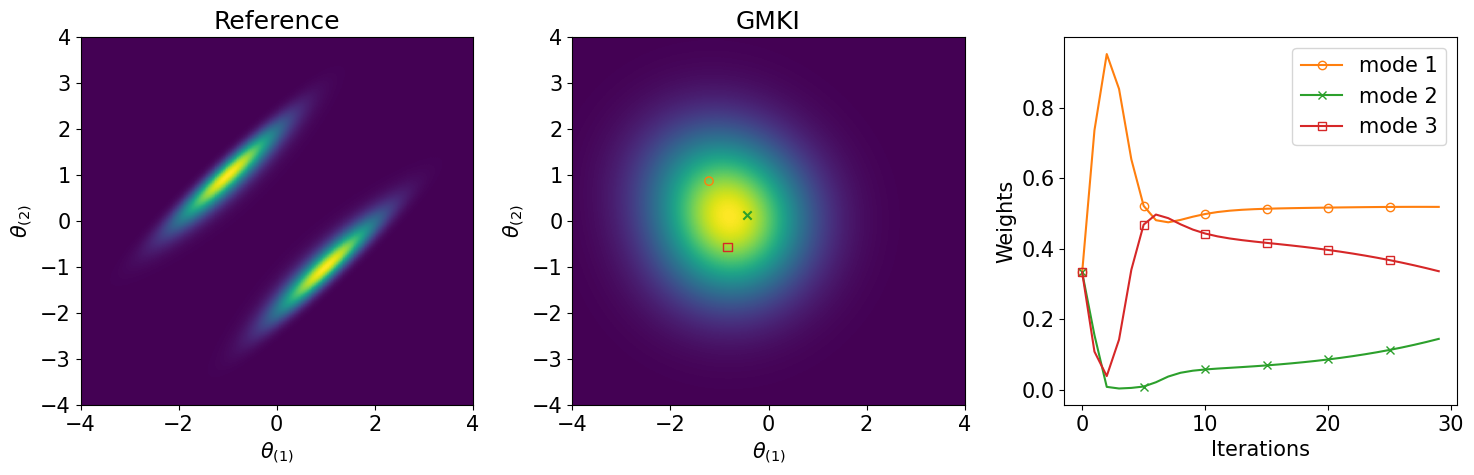

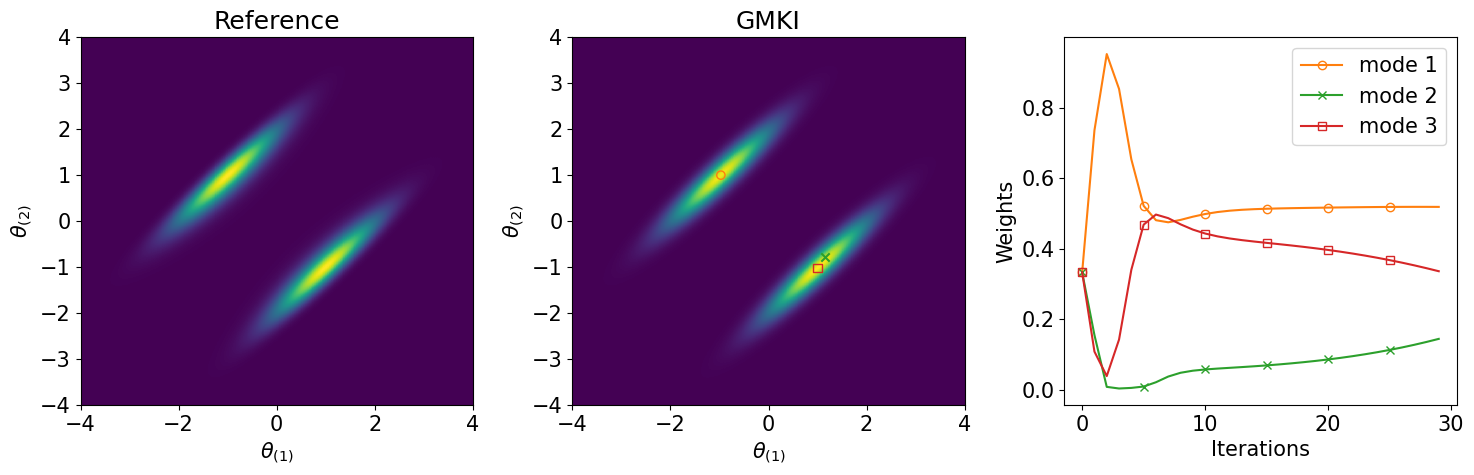

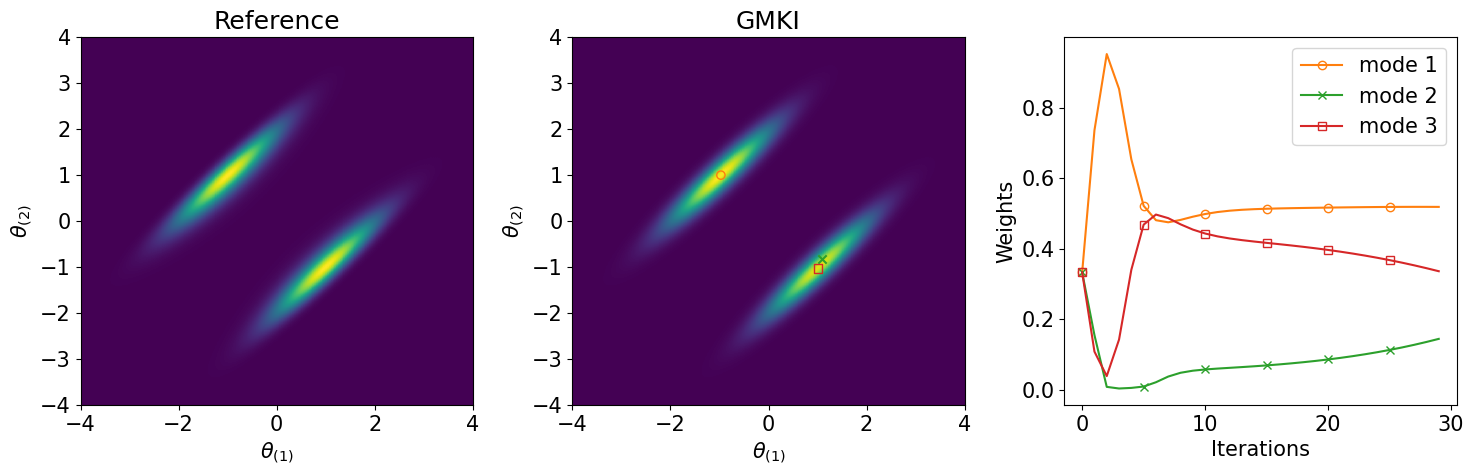

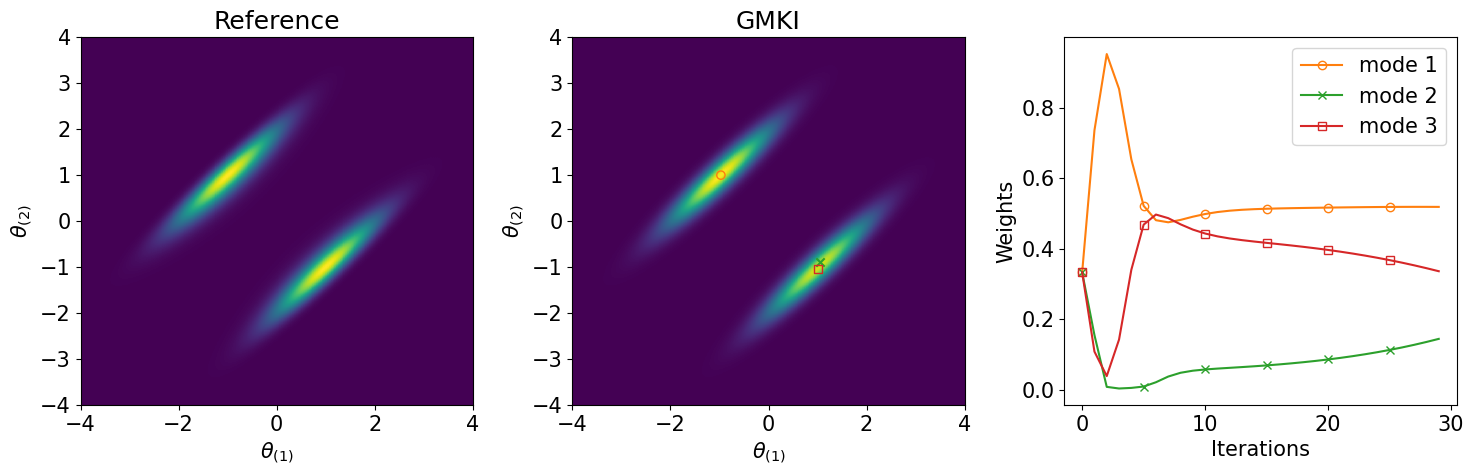

In [24]:
double_banana([0.0;0.0])

┌ Info: ("y = ", [4.2297])
└ @ Main In[23]:11
┌ Info: ([1.0;;], [1.0 0.0; 0.0 1.0])
└ @ Main In[23]:52
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:81
┌ Info: ("iter = ", 1, " i = ", 1, [-0.7141570148792402, 0.8728141561713048], -1.0986122886681098)
└ @ Main In[23]:124
┌ Info: ("iter = ", 1, " i = ", 2, [0.05267745195470952, 0.14532188192398446], -1.0986122886681098)
└ @ Main In[23]:124
┌ Info: ("iter = ", 1, " i = ", 3, [-0.3369753246696554, -0.5651412530035561], -1.0986122886681098)
└ @ Main In[23]:124
┌ Info: ("iter = ", 11, " i = ", 1, [-0.7144079984357373, 1.2443941974976986], -1.2418753916999128)
└ @ Main In[23]:124
┌ Info: ("iter = ", 11, " i = ", 2, [1.4326467453965253, -0.5925110758418287], -1.1867280388029764)
└ @ Main In[23]:124
┌ Info: ("iter = ", 11, " i = ", 3, [1.15486983049452, -0.8727328980424828], -0.901550682699525)
└ @ Main In[23]:124
┌ Info: ("iter = 

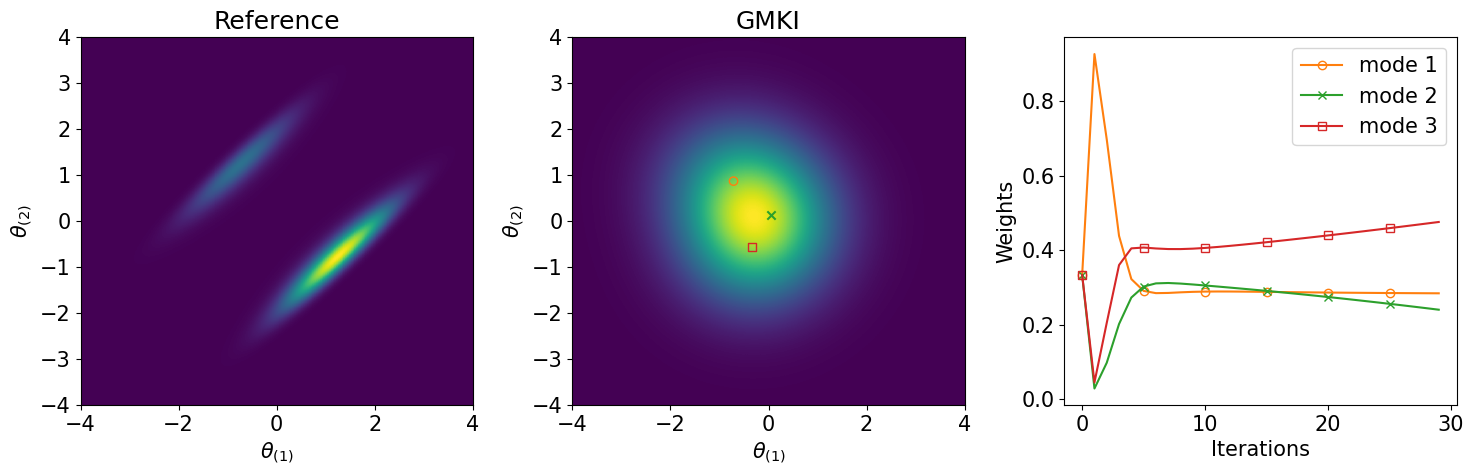

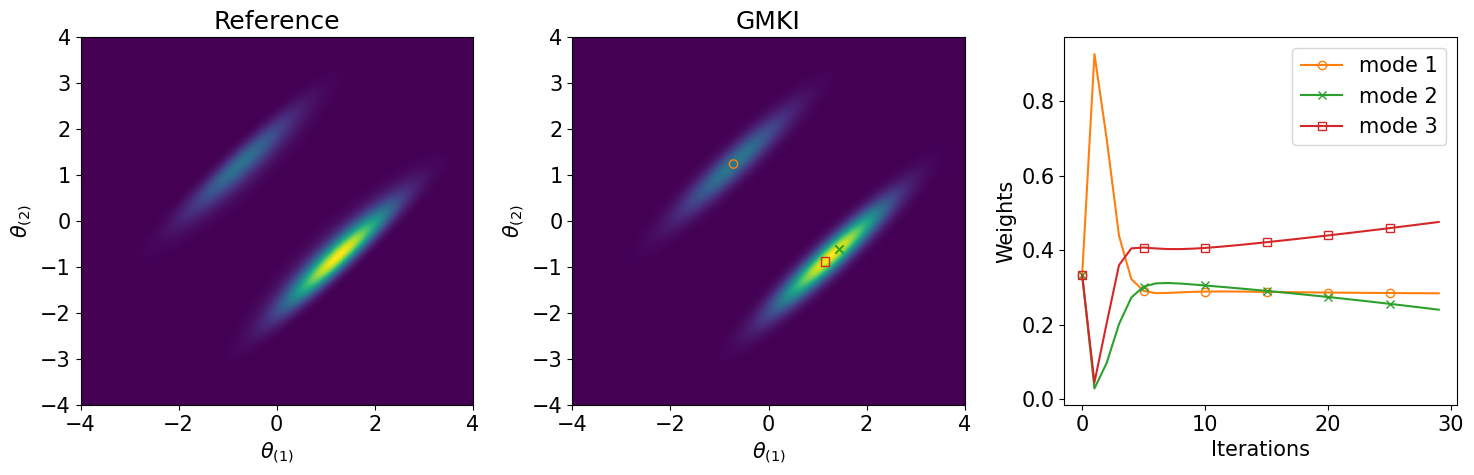

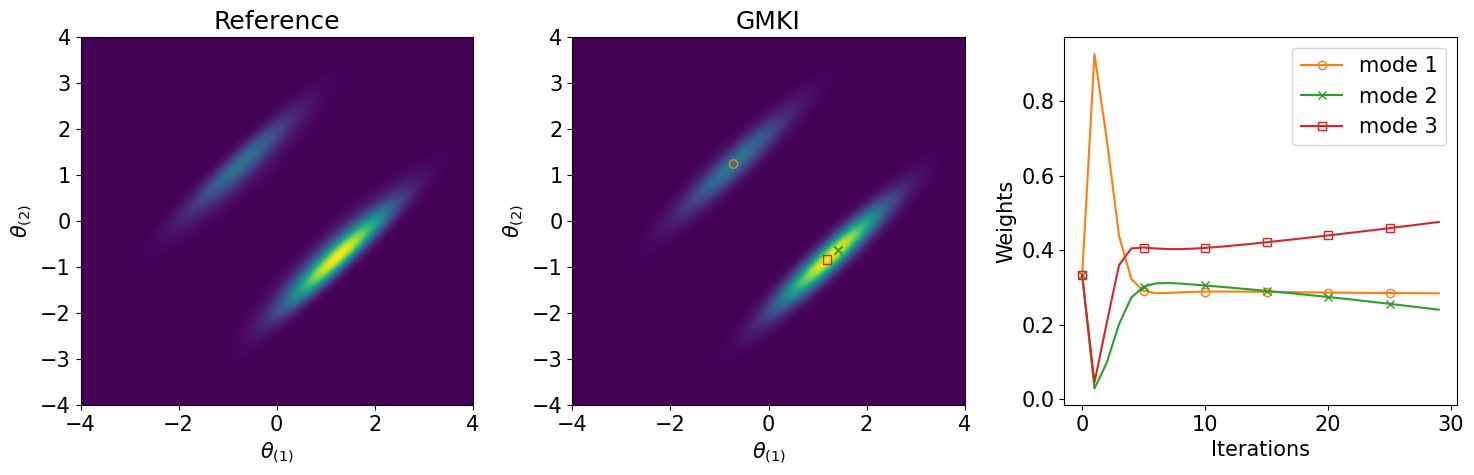

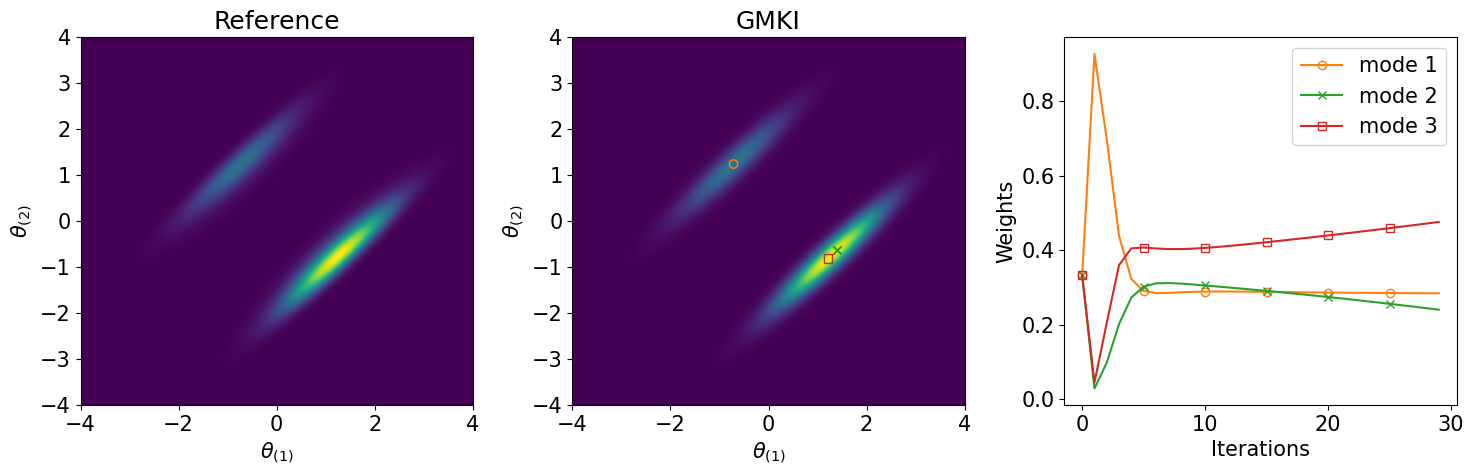

In [25]:
double_banana([0.5;0.0])